# First 1D Water Isotope Diffusion Model

Liam Kirkpatrick

Jan 17, 2024

IBIS project on water isotope diffusion

### Import packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib


from mpl_toolkits.axes_grid1 import make_axes_locatable

### Define Forward Euler scheme algorithm for solving diffusion equation

Here I draw from: https://hplgit.github.io/fdm-book/doc/pub/diffu/pdf/diffu-4print.pdf, https://zsylvester.github.io/post/diffusion_equation/, and https://www.uni-muenster.de/imperia/md/content/physik_tp/lectures/ws2016-2017/num_methods_i/heat.pdf. However, I end up choosing to write my own function here.


In [2]:
def diffusion(t,z,z0,zmax,I,D):
# function
#     Computes diffusion using a 1D euler method approach
# Inputs:
#     t    - vectors of time for the run (UNITS: years)
#     z    - vector of vertical (1D) grid spacing (UNITS: m)
#     z0   - boundary condition, upper side (UNITS: permille)
#     zmax - boundary condition, lower side (UNITS: permille)
#     I    - vector of inital condition (UNITS: permille)
#     D    - Diffusion coefficent (UNITS: m^2/s)
# Outputs:
#     T    - matrix of results, where first axis is time and seccond axis is vertical grid (UNITS: permille)

    
    # find dt (convert to secconds) and dz
    dt = (t[1]-t[0]) * 365.25 * 24 * 60 * 60
    dz = z[1]-z[0]
    
    # find number of timesteps and distance steps
    nt = len(t)
    nz = len(z)
    
    # calculate diffusion number
    d = D * dt / (dz**2)
    print(d)
    
    # check stability
    if dt > (0.5*dz**2 / D):
        print("******************************")
        print("******************************")
        print
        print("******************************")
        print("******************************")
        
    
    # create matrix of results. Set full of zeros for now
    T = np.zeros((nt,nz))
    
    # set first line of matrix to initial conditions, set endges to boundary conditions
    T[0,:] = I
    T[0,0] = z0
    T[0,-1] = zmax
    
    # loop through all timesteps (from 1:end)
    for j in range(1,nt):
        
        # loop through all grid points (except left/right side)
        for i in range(1,nz-1):
            
            # solve for gridpoint at this time step
                # this draws on this point, the point above, and the point below at the prior timestep
            T[j,i] = T[j-1,i] + d * (T[j-1,i-1] - 2*T[j-1,i] + T[j-1,i+1])
            
            #s*(V[n,j-1] - 2*V[n,j] + V[n,j+1])

        # set endpoints
        T[j,0] = z0
        T[j,-1] = zmax
        
    return(T)

### Define initial and boundary conditions, time vector, etc


In [3]:
# set time vector
years = 1*10**6
t = np.linspace(0,years,10**6+1)

# set boundary conditions
z0 = -50
zmax = -50

# set space vector
z = np.linspace(0,1,101)

# set inital conditions
I = np.ones(len(z)) * (z0+zmax)/2
period_sin = 21
sin_amp = 10
for i in range(period_sin):
    
    midpt = math.ceil(len(z)/2)
    index = midpt - math.floor(period_sin/2) + i
    
    I[index] = I[index] + sin_amp * math.sin(i/period_sin * 2*math.pi)

### Run at a signle temperature

In [4]:
# set temperature (in Kelvin)
T = 260

# Calculate diffusion coefficent (following Gkinis et al., 2014)
D = 9.2 * 10**(-4) * math.exp(-7186/T) # units m^2/s

run1 = diffusion(t,z,z0,zmax,I,D)

0.0002881777591429048


### Plot Result

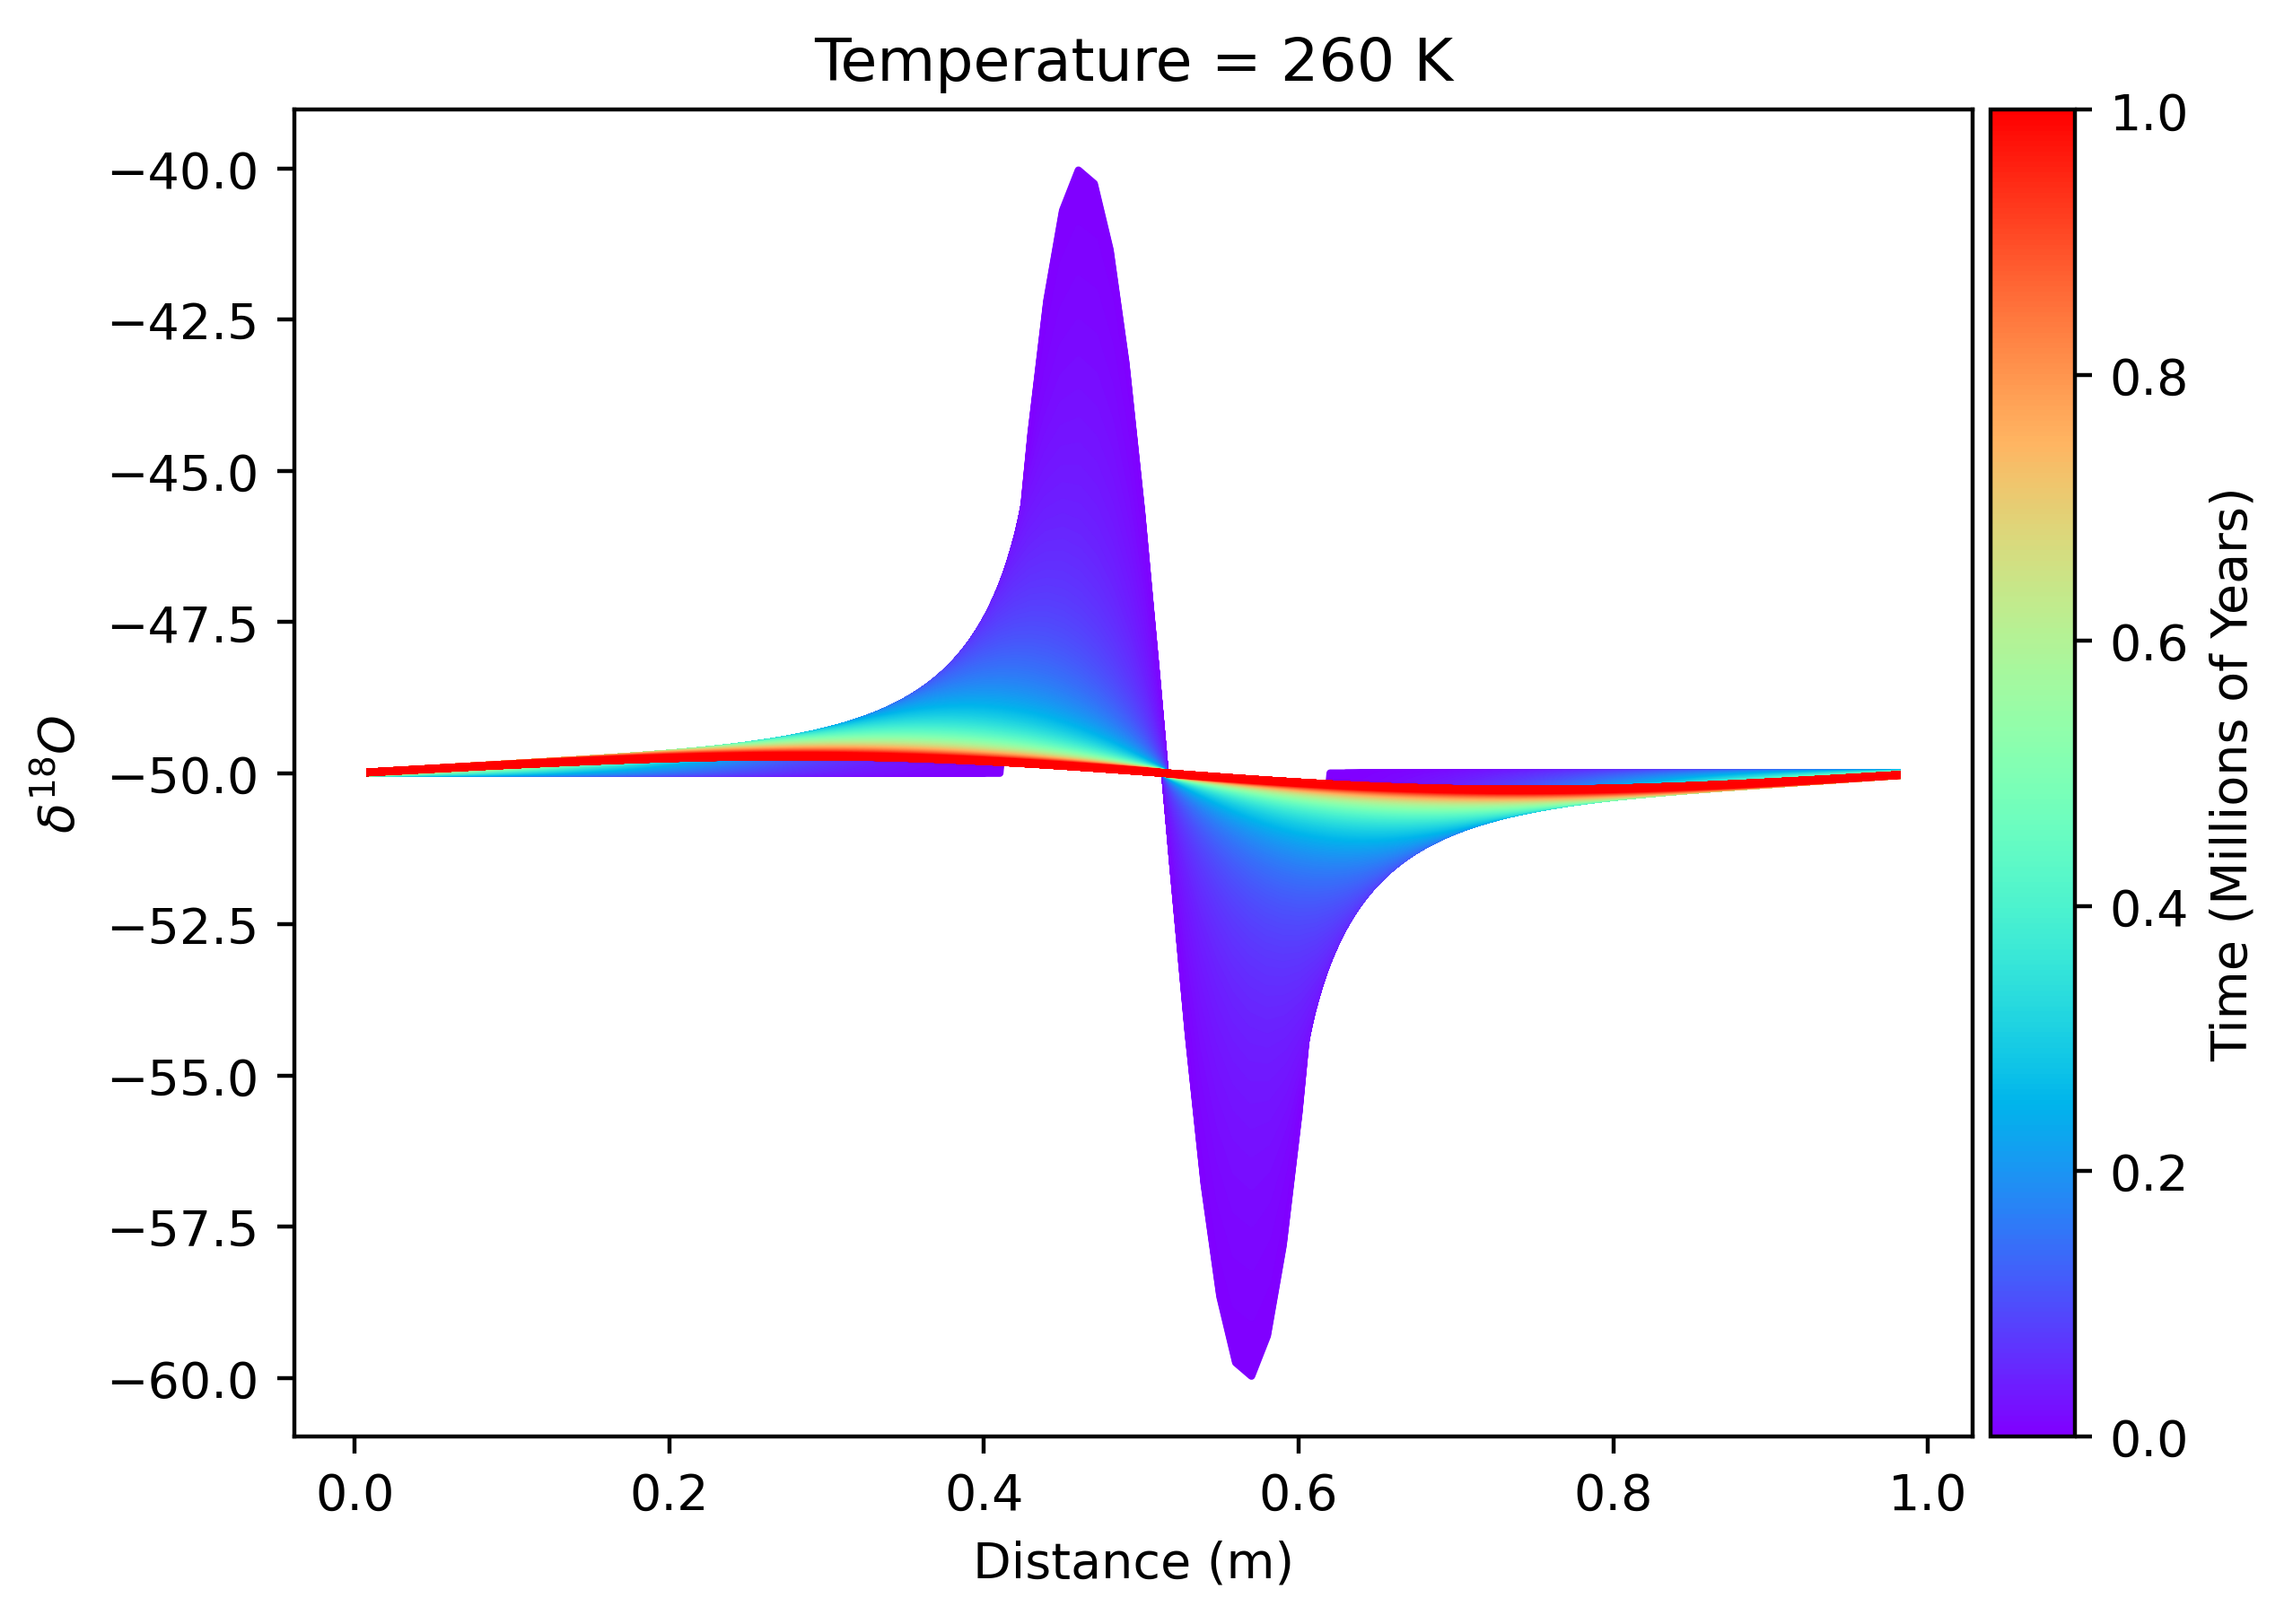

In [5]:
# make figure
fig, axs = plt.subplots(dpi=400)
axs.set_title('Temperature = '+str(T)+' K')
axs.set_ylabel(r'$\delta^{18}O$')
axs.set_xlabel('Distance (m)')

# set colormap and add colorbar
norm = matplotlib.colors.Normalize(vmin=np.min(t)*10**-6,vmax=np.max(t)*10**-6)
cmap = matplotlib.colormaps.get_cmap('rainbow')
s_m = matplotlib.cm.ScalarMappable(cmap=cmap,norm=norm)
s_m.set_array([])
divider = make_axes_locatable(axs)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(s_m,cax=cax,label='Time (Millions of Years)')

#plot a single year
for i in range(0,len(t),100):
    axs.plot(z[1:-2],run1[i,1:-2],color=cmap(i/len(t)))
